In [8]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [9]:
print("Loading dataset...")
csv_files = glob.glob("dataset/*.csv")
dfs = []
for f in csv_files:
    try:
        df = pd.read_csv(f, encoding="utf-8")
        if "text" in df.columns and "label" in df.columns:
            dfs.append(df[["text", "label"]])
        elif "text_combined" in df.columns and "label" in df.columns:
            df = df.rename(columns={"text_combined": "text"})
            dfs.append(df[["text", "label"]])
        elif "body" in df.columns and "label" in df.columns:
            df = df.rename(columns={"body": "text"})
            dfs.append(df[["text", "label"]])
        else:
            print(f"[!] Skipping {f} due to missing text/label columns.")
    except Exception as e:
        print(f"[!] Failed to read {f}: {e}")

Loading dataset...


In [10]:
df = pd.concat(dfs, ignore_index=True)
df.dropna(subset=["text", "label"], inplace=True)
df["label"] = df["label"].astype(int)
print(df.head()) #For Checking if it works

                                                text  label
0  Buck up, your troubles caused by small dimensi...      1
1  \nUpgrade your sex and pleasures with these te...      1
2  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...      1
3  Would anyone object to removing .so from this ...      0
4  \nWelcomeFastShippingCustomerSupport\nhttp://7...      1


In [11]:
#Training the model
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.95)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)

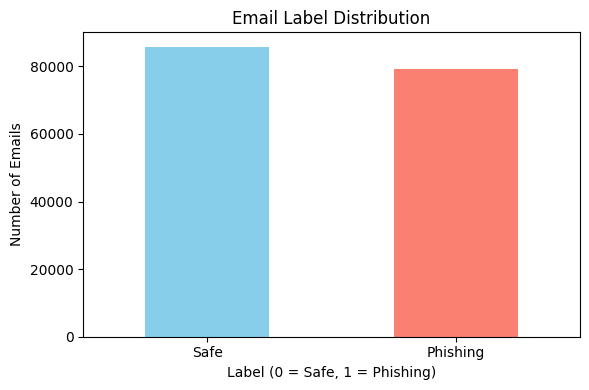

In [15]:
# 1. Plot Label Distribution
plt.figure(figsize=(6, 4))
label_counts = df["label"].value_counts()
label_counts.plot(kind="bar", color=["skyblue", "salmon"])
plt.title("Email Label Distribution")
plt.xlabel("Label (0 = Safe, 1 = Phishing)")
plt.ylabel("Number of Emails")
plt.xticks(ticks=[0, 1], labels=["Safe", "Phishing"], rotation=0)
plt.tight_layout()
plt.show()

C:\Users\vvina\AppData\Local\Temp\ipykernel_3844\2721689870.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette="Reds_r")


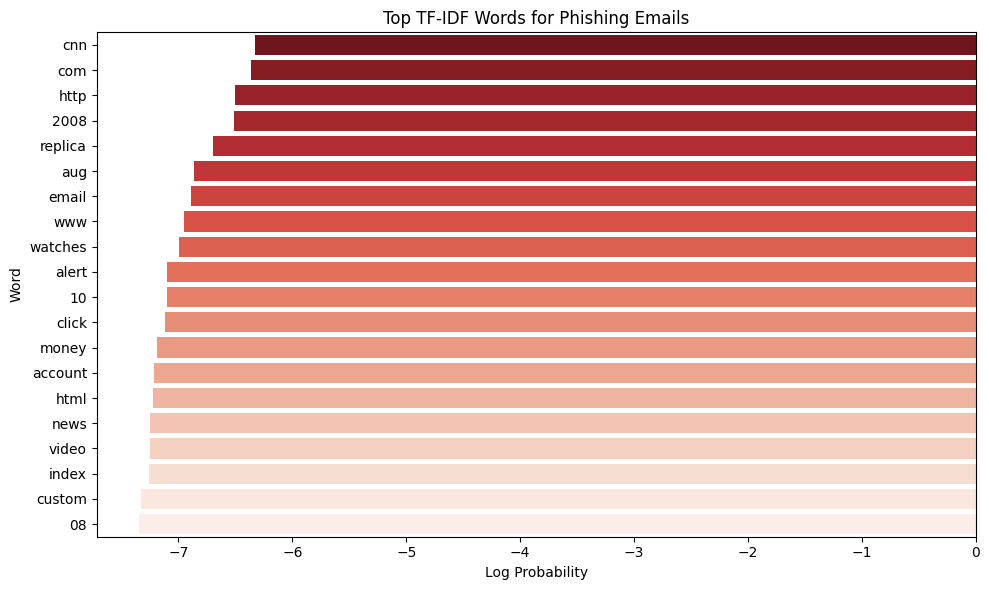

In [14]:
# 2. Plot Top 20 TF-IDF Features for Phishing Class
feature_names = vectorizer.get_feature_names_out()
phishing_log_probs = clf.feature_log_prob_[1]  # class 1 = phishing
top_n = 20
top_indices = phishing_log_probs.argsort()[-top_n:][::-1]  # highest log probs
top_words = [feature_names[i] for i in top_indices]
top_scores = phishing_log_probs[top_indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_scores, y=top_words, palette="Reds_r")
plt.title("Top TF-IDF Words for Phishing Emails")
plt.xlabel("Log Probability")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

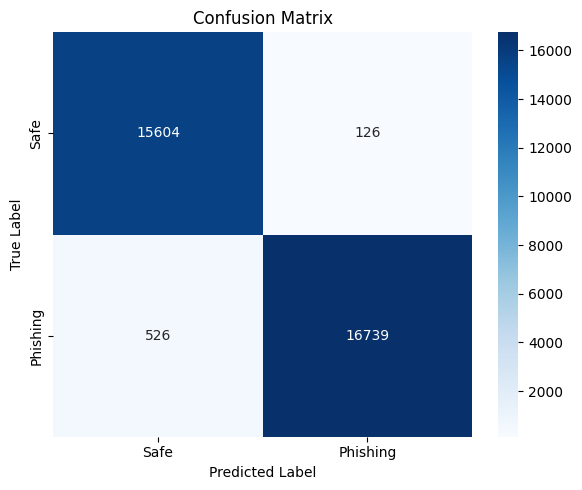

In [13]:
# 3. Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Safe", "Phishing"], yticklabels=["Safe", "Phishing"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
#Accuracy ans saving the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
joblib.dump(clf, "phishing_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
print("Model and vectorizer saved.")



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     15730
           1       0.99      0.97      0.98     17265

    accuracy                           0.98     32995
   macro avg       0.98      0.98      0.98     32995
weighted avg       0.98      0.98      0.98     32995

Accuracy: 0.9802394302166995
Model and vectorizer saved.
